In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle
import re
from pathlib import Path
import scipy.stats as ss
from scipy.optimize import curve_fit
import seaborn as sns
import sys
sys.path.append(os.path.join(Path(os.getcwd()).parents[0], "functions"))
import warnings
warnings.filterwarnings('ignore')
import helper_functions as hfn
from matplotlib import gridspec

In [2]:
from lmfit import Model
from lmfit.models import LinearModel
model_lm = LinearModel()

In [3]:
colors =  ["indigo", "purple", "red", "orange", 'light orange']

sns.set_palette = sns.xkcd_palette(colors)
sns.set_style("ticks")
hfont = {'fontname':'Myriad Pro'}

In [4]:
def make_res_inputratio_noplot(res_df):
    n = len(res_df.area.unique())
    res_df['new'] = (res_df.index/n+1).astype(int)
    res_df['TotalInputs'] = res_df.groupby('new')['inputs'].transform('sum')
    res_df['area_ratio'] = res_df['inputs']/ res_df['TotalInputs']
    return res_df

In [5]:
def make_res_ci_noplot(res_df):
    n = len(res_df.area.unique())
    res_df['area_ci'] = res_df['inputs']/ res_df['starters']
    return res_df

In [6]:
def func(x, a, b, c):
	return a * x**2 + b * x + c

In [7]:
def func3(x, a, b, c, d):
	return a * x**3 + b * x**2 + c * x + d

In [10]:
path = Path(os.getcwd()).parents[0]

prob_path = os.path.join(path, 'data/network_models/probabilistic_model')

datapath = os.path.join(prob_path, 'input_fractions')

datapath_res = os.path.join(datapath, 'results')

datapath_res_p = os.path.join(datapath_res, 'input_ratio_ni_cst')
datapath_res_ni = os.path.join(datapath_res, 'input_ratio_p_cst')
datapath_res_p_ni = os.path.join(datapath_res, 'input_ratio')

figpath = os.path.join(path, 'figures')
hfn.dir_check(figpath)

figs51path = os.path.join(figpath, 'FigS17')
hfn.dir_check(figs51path)

figs51panelpaths = os.path.join(figs51path, 'panels')
hfn.dir_check(figs51panelpaths)

# plot data - Ni varying

In [11]:
with open(os.path.join(datapath_res_ni, 'ni_arr.pickle'), 'rb') as fp:
    ni_arr = pickle.load(fp)

In [12]:
ni_arr_df = pd.DataFrame(ni_arr)
ni_arr_df['range'] = ni_arr_df.max(axis = 1) - ni_arr_df.min(axis = 1)
test_ind_ni = ni_arr_df['range'].argmax()

In [13]:
allfiles_ni = [f for f in os.listdir(datapath_res_ni) if (os.path.isfile(os.path.join(datapath_res_ni, f)) & f.startswith('res'))]

In [14]:
# load file for example plots
thisfile_ni = os.path.join(datapath_res_ni, 'res_df_' + str(test_ind_ni)+'.h5')
thisdf_ni = pd.read_hdf(thisfile_ni)

In [15]:
thisdf_ni = make_res_inputratio_noplot(thisdf_ni)

In [16]:
thisdf_ni = make_res_ci_noplot(thisdf_ni)

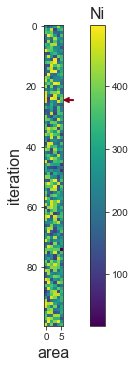

In [17]:
f1= plt.figure(figsize = (5,5), constrained_layout=True)
ax = plt.gca()
im = plt.imshow(ni_arr_df, cmap = 'viridis')
plt.ylabel('iteration', fontsize = 16)
plt.xlabel('area', fontsize = 16)

ax.annotate('', xy=(0.9, 0.75), xycoords='axes fraction', xytext=(1.7,0.75), 
            arrowprops=dict(arrowstyle="->", color='xkcd:crimson',lw=2))
cbar = f1.colorbar(im)
cbar.ax.set_title('Ni', fontsize = 16)
plt.savefig(os.path.join(figs51panelpaths, 'figS17a.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs51panelpaths, 'figS17a.eps'), bbox_inches = 'tight', format = 'eps')

In [18]:
thisdf_ni['Ni']= thisdf_ni.apply(lambda row: ni_arr_df.iloc[test_ind_ni, int(row.area)], axis=1)
thisdf_ni = thisdf_ni.sort_values(by=['Ni'])
thisdf_ni['area_ni'] = thisdf_ni.groupby('Ni').ngroup()+1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


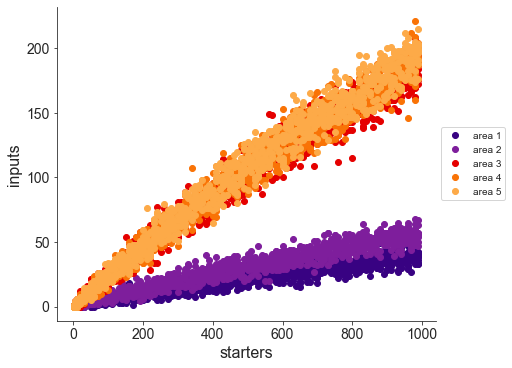

In [19]:
f2 = plt.figure(figsize = (7,5), constrained_layout=True)
for i in range(5):
    this_res_df = thisdf_ni[thisdf_ni.area_ni == i+1]
    plt.plot(this_res_df.starters, this_res_df.inputs, 'o', c = sns.xkcd_palette(colors)[i], label = 'area ' + str(i+1))#+ '\nNi = 100, p = '+ "{:.4f}".format(p_arr_df.iloc[42, i]))
plt.xlabel('starters', fontsize = 16)
plt.ylabel('inputs', fontsize = 16)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(figs51panelpaths, 'figS17b.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs51panelpaths, 'figS17b.eps'), bbox_inches = 'tight', format = 'eps')

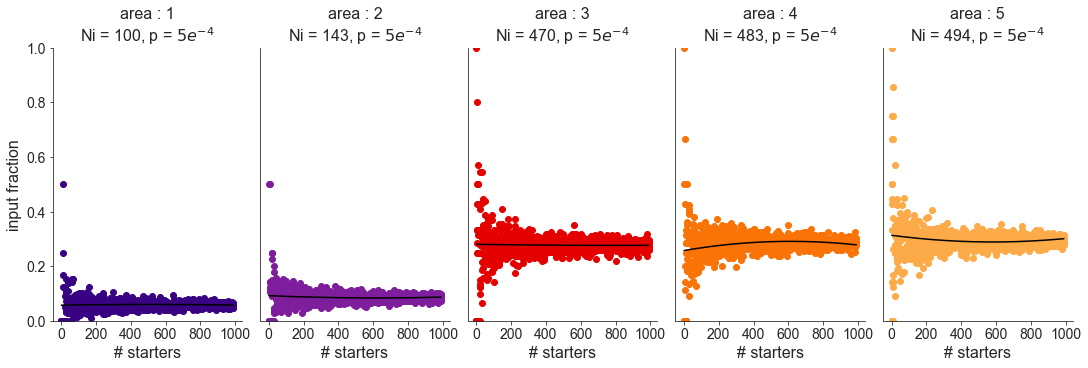

In [20]:
f3 = plt.figure(figsize = (15,5), constrained_layout = True)

gs = f3.add_gridspec(1,5)

ax = {}
for i in range(5):
    ax[i] = f3.add_subplot(gs[:, i:(i)+1])#(1, 5 , i+1)
    this_res_df = thisdf_ni[thisdf_ni.area_ni == i+1].dropna()
    this_res_df = this_res_df.sort_values(by=['starters'])
    thisx = this_res_df.starters
    thisy = this_res_df.area_ratio
    popt, pcov = curve_fit(func, thisx, thisy)
    
    ax[i].plot(this_res_df.starters, this_res_df.area_ratio, 'o', c = sns.xkcd_palette(colors)[i])#'C'+str(i))
    ax[i].plot(thisx, func(thisx, *popt), c = 'k')
    ax[i].set_title('area : ' + str(i+1) + '\nNi = '+ "{:d}".format(this_res_df.Ni.unique()[0])+ ', p = $5e^{-4}$', fontsize = 16)
    ax[i].set_ylim(0,1)
    ax[i].set_xlabel('# starters', fontsize = 16)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        label.set_fontsize(14)
        
for i in [1,2,3,4]:
    ax[i].yaxis.set_visible(False)
ax[0].set_ylabel('input fraction', fontsize = 16)
plt.savefig(os.path.join(figs51panelpaths, 'figS17d.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs51panelpaths, 'figS17d.eps'), bbox_inches = 'tight', format = 'eps')

In [21]:
this_df_an_ni = []
for file in allfiles_ni:
    thisind = re.search(r'\d+', file).group()
    thisfile = os.path.join(datapath_res_ni, file)
    thisdf = pd.read_hdf(thisfile)
    thisdf = make_res_inputratio_noplot(thisdf)
    for area in range(5):
        dfarea = thisdf[thisdf.area == area].dropna()
        # fit polynomial
        thisx = dfarea.starters
        thisy = dfarea.area_ratio
        popt, pcov = curve_fit(func, thisx, thisy)
        dfarea['fit'] = func(thisx, *popt)
        dfarealow = dfarea[dfarea.starters <= 100].dropna()
        dfareahigh = dfarea[dfarea.starters >= 900].dropna()
        xlow = dfarealow.starters
        ylow = dfarealow.area_ratio

        xhigh = dfareahigh.starters
        yhigh = dfareahigh.area_ratio

        pars_low = model_lm.guess(ylow, x = xlow)
        results_low = model_lm.fit(ylow, pars_low, x = xlow)

        pars_high = model_lm.guess(yhigh, x = xhigh)
        results_high = model_lm.fit(yhigh, pars_high, x = xhigh)
        this_df_an_ni.append({'ind': thisind, 'area' : area, 'ratio_low' : dfarealow.area_ratio.mean(), 'ratio_high' : dfareahigh.area_ratio.mean(), 'ratio_fit_low' : dfarealow.fit.mean(), 'ratio_fit_high' : dfareahigh.fit.mean(), 'slope_low' : results_low.params['slope'].value, 'slope_high' : results_high.params['slope'].value})
an_df_ni = pd.DataFrame(this_df_an_ni)

In [22]:
an_df_ni['ratio_fit_diff'] = an_df_ni['ratio_fit_high'] - an_df_ni['ratio_fit_low']
an_df_ni['ratio_fit_ratio'] = an_df_ni['ratio_fit_high'] / an_df_ni['ratio_fit_low']

In [23]:
an_toplot_ni = an_df_ni[['ind','area','ratio_fit_low']]
an_toplot_ni.columns = ['ind','area','ratio_fit']
an_toplot_ni['starters'] = 'low'

an_toplot2_ni = an_df_ni[['ind','area','ratio_fit_high']]
an_toplot2_ni.columns = ['ind','area','ratio_fit']
an_toplot2_ni['starters'] = 'high'

an_toplot_ni = pd.concat([an_toplot_ni, an_toplot2_ni], axis =0)

In [24]:
this_an_df_ni = an_df_ni[an_df_ni.ind == str(test_ind_ni)]

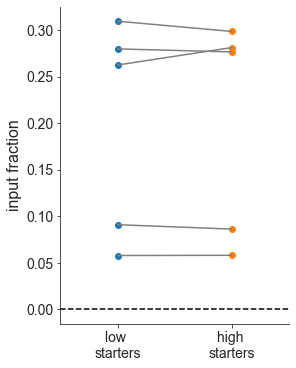

In [25]:
f4= plt.figure(figsize = (4,5), constrained_layout=True)
plt.scatter(np.ones(5), this_an_df_ni.ratio_fit_low, label = 'low starters')
plt.scatter(np.ones(5)*1.5, this_an_df_ni.ratio_fit_high, label = 'high starters')
plt.plot([np.ones(5),np.ones(5)*1.5], [this_an_df_ni.ratio_fit_low,this_an_df_ni.ratio_fit_high], 'gray')
plt.axhline(0, c = 'k', ls = '--')

plt.xlim(0.75, 1.75)
plt.xticks([])

text_values = ["low \nstarters", "high \nstarters"]
x_values = [1, 1.5]
plt.xticks(x_values, text_values)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
plt.ylabel('input fraction', fontsize = 16)
plt.savefig(os.path.join(figs51panelpaths, 'figS17c.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs51panelpaths, 'figS17c.eps'), bbox_inches = 'tight', format = 'eps')


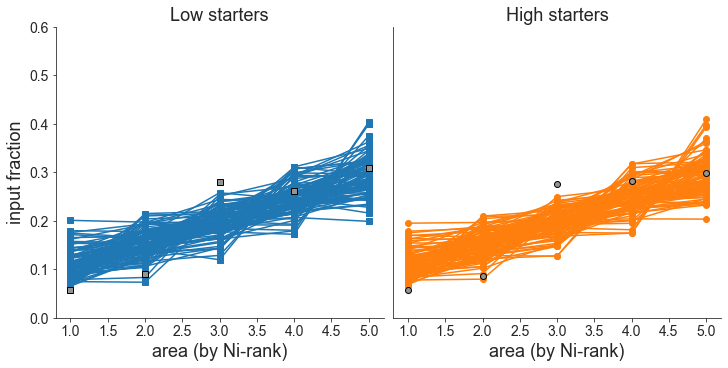

In [26]:
f5 = plt.figure(figsize = (10,5), constrained_layout = True)

gs = f5.add_gridspec(1,4)


ax1 = f5.add_subplot(gs[:, 0:2])
ax2 = f5.add_subplot(gs[:, 2:])
for ind in range(100):
    if ind == test_ind_ni:
        col0 = 'xkcd:grey'
        col1 = 'xkcd:grey'
        mec0 = 'k'
        mec1 = 'k'
        z = 1
        alph = 1
        ls0 = 's'
        ls1 = 'o'
    else:
        col0 = 'C0'
        col1 = 'C1'
        mec0 = 'C0'
        mec1 = 'C1'
        z = -1
        alph = 1
        ls0 ='s-'
        ls1 = 'o-'
    this_an_df = an_df_ni[an_df_ni.ind == str(ind)]
    this_an_df['Ni'] = this_an_df.apply(lambda row : ni_arr_df.iloc[int(row.ind), int(row.area)], axis=1)
    this_an_df = this_an_df.sort_values(by = ['Ni'])
    ax1.plot(np.arange(5)+1,this_an_df.ratio_fit_low, ls0, c = col0, alpha = alph, zorder = z, mec = mec0)
    ax2.plot(np.arange(5)+1,this_an_df.ratio_fit_high, ls1, c = col1, alpha = alph, zorder = z, mec = mec1)

ax1.set_ylim(0, 0.6)
ax2.set_ylim(0, 0.6)
ax2.yaxis.set_visible(False)
ax1.set_ylabel('input fraction', fontsize = 18)
ax1.set_xlabel('area (by Ni-rank)', fontsize = 18)
ax2.set_xlabel('area (by Ni-rank)', fontsize = 18)

ax1.set_title('Low starters', fontsize = 18)
ax2.set_title('High starters', fontsize = 18)


ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(14)
plt.savefig(os.path.join(figs51panelpaths, 'figS17e.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs51panelpaths, 'figS17e.eps'), bbox_inches = 'tight', format = 'eps')


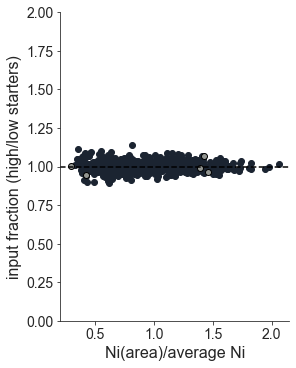

In [27]:
f6 = plt.figure(figsize = (4,5), constrained_layout = True)
for ind in range(99):
    this_an_df = an_df_ni[an_df_ni.ind == str(ind)]
    if ind == test_ind_ni:
        col = 'xkcd:grey'
        mec = 'k'
        z = 1
    else:
        col = 'xkcd:dark'
        mec = 'xkcd:dark'
        z = -1
    plt.plot(ni_arr_df.iloc[ind, 0:5]/ni_arr_df.iloc[ind, 0:5].mean(),this_an_df.ratio_fit_ratio, 'o', c = col, mec = mec, zorder = z)

plt.axhline(1, ls = '--', c = 'k')
plt.xlabel('Ni(area)/average Ni', fontsize = 16)
plt.ylabel('input fraction (high/low starters)', fontsize = 16)
plt.ylim(0,2)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(14)
plt.savefig(os.path.join(figs51panelpaths, 'figS17f.png'), bbox_inches = 'tight')
plt.savefig(os.path.join(figs51panelpaths, 'figS17f.eps'), bbox_inches = 'tight', format = 'eps')